In [175]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
import torch
from preprocess.preprocess import JointDataset
from model.vae import VAE
from plot.plot import plot_skeleton_3d, plot_loss
from utils.utils import find_device, path_to_alphanumeric
import os
import pandas as pd
import numpy as np
import glob

In [177]:
device = find_device(force_cpu=True)
print("Using device", device)

Using device cpu


In [178]:
data_folder = "/Volumes/Crucial X8/csi_depth_camera/data"
assert os.path.exists(data_folder), "path to data does not exist"

bkp_folder = "data/bkp"
os.makedirs(bkp_folder, exist_ok=True)

bkp_name = path_to_alphanumeric(data_folder)

bkp_file = f"{bkp_folder}/{bkp_name}.pt"

In [179]:
# files = []
# runs = glob.glob(f"{data_folder}/run_*")
# for r in runs:
#     labels = glob.glob(f"{r}/processed/labelled/camera/joints/sit_stand/front/*")
#     for lb in labels:
#         files += glob.glob(f"{lb}/*")
# 
# print("number of files", len(files))
# joint_names = None
# xs = []
# for f in files:
#     # "data/unlabelled/camera/joints/front_sit_stand.csv"
#     with open(f, 'r') as f_:
#         df = pd.read_csv(
#             f_, names=["frame_id", "timestamp", "joint_name", "x", "y", "z"])
#         if not len(df):
#             continue
#     
#     # Get the unique joint names and frame IDs
#     joint_names = np.sort(df["joint_name"].unique())
#     frame_ids = df["frame_id"].unique()
#     
#     n_joint = len(joint_names)
# 
#     for f_id in frame_ids:
#         if len(df[df.frame_id == f_id]) != n_joint:
#             df = df[df.frame_id != f_id]
#             frame_ids = frame_ids[frame_ids != f_id]
#             
#     # Create a multi-index using 'frame_id' and 'joint_names'
#     df.set_index(['frame_id', 'joint_name'], inplace=True)
# 
#     # Sort the index to ensure the data is in the correct order
#     df.sort_index(inplace=True)
# 
#     # Convert the DataFrame to a NumPy array and reshape it
#     x = df[['x', 'y', 'z']].values.reshape((frame_ids.size, joint_names.size, 3))
#     
#     # Add to the list
#     xs.append(x)
# 
# # 
# x = np.concatenate(xs)
# 
# # Convert the NumPy array to a PyTorch tensor
# x = torch.from_numpy(x).float().to(device)
# 
# # print("initial shape", x.size()) 
# dataset = JointDataset(joint_names=joint_names, x=x)
# torch.save(dataset, bkp_file)

In [180]:
train_dataset = torch.load(bkp_file)

In [181]:
# Load the data
# train_dataset = make_joint_dataset(device=device, folder=folder)

In [182]:
vae = VAE.train_routine(train_dataset=train_dataset, device=device, 
                        w_loss_reg=0.0, lr=1e-5, batch_size=64, n_epoch=100)

input_dim 220


100%|██████████| 100/100 [01:01<00:00,  1.63it/s, loss=0.01]


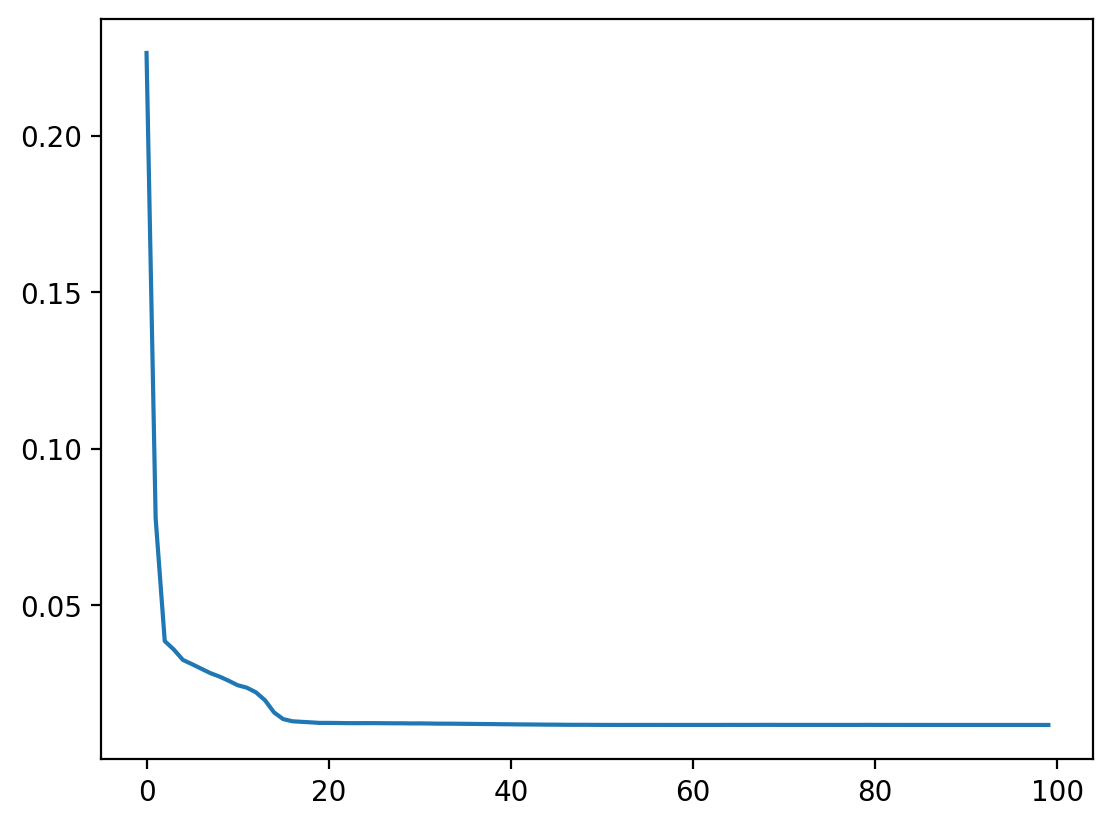

In [183]:
plot_loss(hist_loss=vae.hist_loss)

In [184]:
len(train_dataset.x)

20681

In [190]:
ex_idx = np.random.randint(len(train_dataset.x))
ex = train_dataset.x[ex_idx]

In [191]:
with torch.no_grad():
    decoded, mu, std = vae(ex.clone())
    ex_prime = train_dataset.untransform_and_unscale(decoded.unsqueeze(0)).squeeze(0)

In [192]:
ex_for_plot = train_dataset.untransform_and_unscale(ex.unsqueeze(0)).squeeze(0)

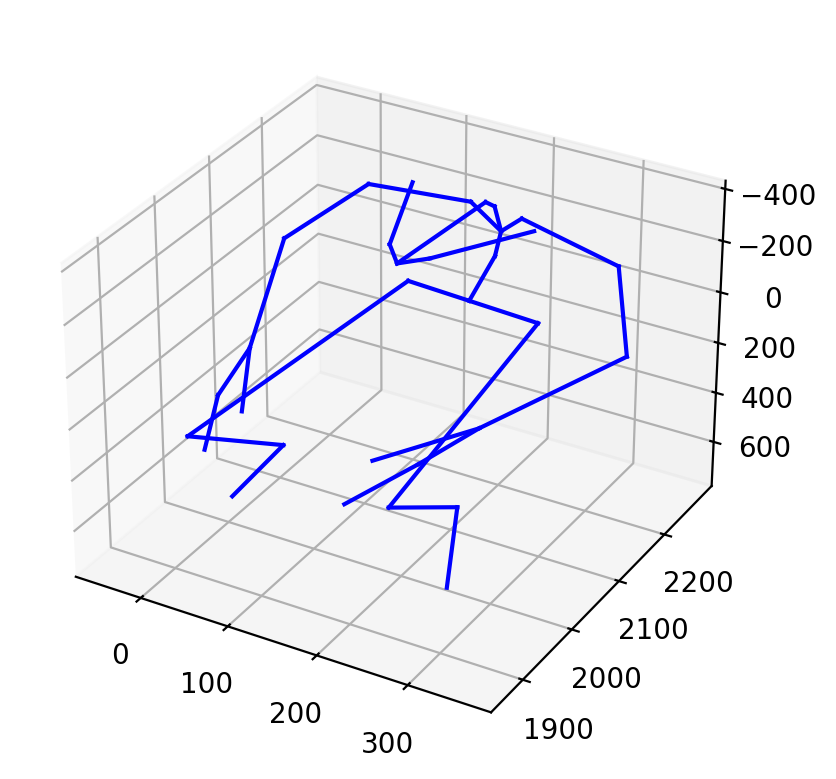

In [193]:
plot_skeleton_3d(ex_for_plot, train_dataset.joint_names)

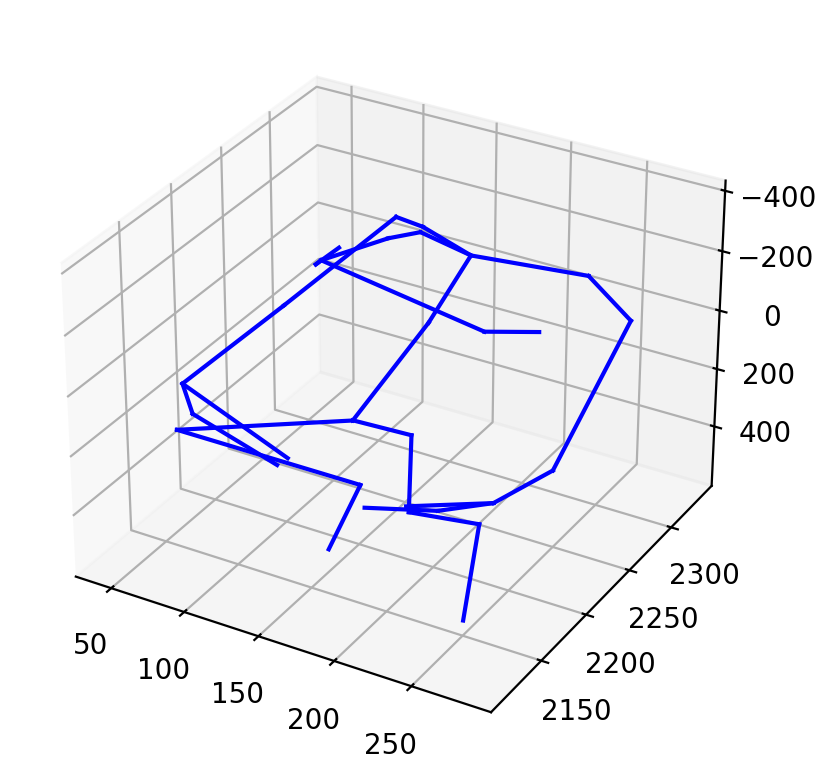

In [194]:
with torch.no_grad():
    smp, mu, std = vae(ex.clone())
    decoded = vae.decode(mu)
    ex_prime = train_dataset.untransform_and_unscale(decoded.unsqueeze(0)).squeeze(0)

plot_skeleton_3d(ex_prime.squeeze(0), train_dataset.joint_names)